In [1]:
#Assignment 7
#Development of a tracking filter of a moving object when measurements and motion
#models are in different coordinate systems
#Team 12
#Yaroslav Savotin, Elizaveta Pestova, Selamawit Asfaw
#Skoltech, 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Function for genereting cartesian coordinates x,y and components of velocity
def generate_Xt(x0,Fi,N):
    Xt = np.zeros((4, 1, N))
    Xt[:, :, 0] = x0
    for i in range(1, N):
        Xt[:, :, i] = np.dot(Fi,Xt[:, :, i-1])
    return Xt

#Function used for genereting polar trajectory
def generate_Polar_Xt(Xt, N):
    D = np.zeros((1, 1, N))
    Beta = np.zeros((1, 1, N))
    for i in range(N):
        D[:, :, i] = np.sqrt(Xt[0, 0, i]**2 + Xt[2, 0, i]**2)
        Beta[:, :, i] = np.arctan(Xt[0, 0, i] / Xt[2, 0, i])
    return D, Beta

#Function used for genereting polar measuement
def generate_Polar_Z(sigmaD, sigmaB, D, B, N):
    Dz = np.zeros((1, 1, N))
    Bz = np.zeros((1, 1, N))
    nuD = np.random.normal(0, sigmaD, (1, 1, N))
    nuB = np.random.normal(0, sigmaB, (1, 1, N))
    for i in range(N):
        Dz[:, :, i] = D[:, :, i] + nuD[:, :, i]
        Bz[:, :, i] = B[:, :, i] + nuB[:, :, i]
    return Dz, Bz

#Function for co ordinate transformation(polar to cartesian)
def pseudo_measurement(Dz, Betaz, N):
    Xm = np.zeros((1, 1, N))
    Ym = np.zeros((1, 1, N))
    Zm = np.zeros((2, 1, N))
    for i in range(N):
        Xm[:, :, i] = Dz[:, :, i] * np.sin(Betaz[:, :, i])
        Ym[:, :, i] = Dz[:, :, i] * np.cos(Betaz[:, :, i])
    for i in range(N):
        Zm[0,0,i] = Xm[0][0][i]
        Zm[1,0,i] = Ym[0][0][i]
    return Zm


#Function to calculate R matrix
def Covariance_matrix(sigmaD, sigmaB, Zm, N):
    R = np.zeros((2,2,N))
    for i in range(N):
        R[0,0,i] = ((sigmaD**2)*np.sin(Zm[1,:,i])**2) + (Zm[0,:,i]**2)*(np.cos(Zm[1,:,i])**2)*(sigmaB**2)
        R[0,1,i] = np.sin(Zm[1,:,i])*np.cos(Zm[1,:,i])*((sigmaD**2) - (Zm[0,:,i]**2)*sigmaB**2)
        R[1,0,i] = np.sin(Zm[1,:,i])*np.cos(Zm[1,:,i])*((sigmaD**2) - (Zm[0,:,i]**2)*sigmaB**2)
        R[1,1,i] = (np.cos(Zm[1,:,i])**2)*sigmaD**2 + (Zm[0,:,i]**2)*(np.sin(Zm[1,:,i])**2)*sigmaB**2
    return R


#Kalman filter
def kalmanFilter_from_polar_Z(Fi, H, R, X0, P0, Zm, N):
    Xp = np.zeros((4, 1, N))
    Pf = np.zeros((4, 4, N))
    Pp = np.zeros((4, 4, N))
    Xf = np.zeros((4, 1, N))
    K = np.zeros((4, 2, N))
    Ps = np.zeros((4, 1, N))
    Df = np.zeros((1, 1, N))
    Betaf = np.zeros((1, 1, N))
    Dp = np.zeros((1, 1, N))
    Betap = np.zeros((1, 1, N))
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    
    for i in range(1, N):
        Xp[:, :, i] = np.dot(Fi, Xf[:, :, i-1])
        Pp[:, :, i] = np.dot(np.dot(Fi, Pf[:, :, i-1]), np.transpose(Fi)) 
        K[:, :, i] = np.dot(np.dot(Pp[:, :, i], np.transpose(H)), np.linalg.inv(np.dot(np.dot(H, Pp[:, :, i]), np.transpose(H)) + R[:, :, i]))
        Xf[:, :, i] = Xp[:, :, i] + np.dot(K[:, :, i], (Zm[:, :, i] - np.dot(H, Xp[:, :, i])))
        Pf[:, :, i] = np.dot((np.eye(4) - np.dot(K[:, :, i], H)), Pp[:, :, i])
        Ps[:, :, i] = np.sqrt(np.abs(np.diag(Pf[:, :, i])[0]))
        
        Df[:, :, i] = np.sqrt(Xf[0, 0, i]**2 + Xf[2, 0, i]**2)
        Betaf[:, :, i] = np.arctan(Xf[0, 0, i] / Xf[2, 0, i])
        
        Dp[:, :, i] = np.sqrt(Xp[0, 0, i]**2 + Xp[2, 0, i]**2)
        Betap[:, :, i] = np.arctan(Xp[0, 0, i] / Xf[2, 0, i])
    
    return Xf, K, Dp, Betap, Df, Betaf


#Function that calculate MSE over M run of the Kalman filter

def calculate_MSE(N, M, x0, sigmaD, sigmaB, Fi, H, R, X0, P0):
    Error_run = np.zeros((2, M, N))
    final_Error = np.zeros((1, 2, N))
    Error_run1 = np.zeros((2, M, N))
    final_Error1 = np.zeros((1, 2, N))
    Xf = np.zeros((4, 1, N))
    K = np.zeros((4, 2, N))
    Pot = np.zeros((2, 1, N))
    Pof = np.zeros((2, 1, N))
    Pop = np.zeros((2, 1, N))
    
    for i in range(M):
        Xt = generate_Xt(x0, Fi, N)
        D, Beta = generate_Polar_Xt(Xt, N)
        Dz, Bz = generate_Polar_Z(sigmaD, sigmaB, D, Beta, N)
        Zm = pseudo_measurement(Dz, Bz, N)
        Xf, K, Dp, Betap, Df, Betaf = kalmanFilter_from_polar_Z(Fi, H, R, X0, P0, Zm, N)
        for i in range(N):
            Pot[0,0,i] = D[0][0][i]
            Pot[1,0,i] = Beta[0][0][i]
            
            Pof[0,0,i] = Df[0][0][i]
            Pof[1,0,i] = Betaf[0][0][i]
            
            Pop[0,0,i] = Dp[0][0][i]
            Pop[1,0,i] = Betap[0][0][i]
            
        for j in range(N):
            Error_run[:, i, j] = ((Pot[:, :, j] - Pof[:, :, j]) ** 2).T
            Error_run1[:, i, j] = ((Pot[:, :, j] - Pop[:, :, j]) ** 2).T
    
    for i in range(N):
        for k in range(M):
            final_Error[:, :, i] += Error_run[:, k, i]
            final_Error1[:, :, i] += Error_run1[:, k, i]
        
        final_Error[:, :, i] = np.sqrt(final_Error[:, :, i] / (M - 1))
        final_Error1[:, :, i] = np.sqrt(final_Error1[:, :, i] / (M - 1))
    
    return final_Error, final_Error1

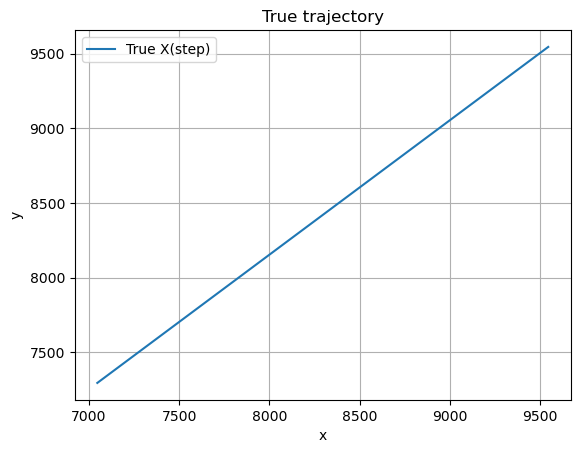

In [3]:
#------------№1------------
# Initial parameters
N = 26
step = np.arange(N)
T = 2

# Initial position and velocity
#[x0,Vx0,y0,Vy0]
x0 = np.array([[13500/np.sqrt(2)], [-50], [13500/np.sqrt(2)], [-45]])


#------------№7------------
# Transition matrix
Fi = np.array([[1, T, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, T],
               [0, 0, 0, 1]])
# Observation matrix
H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

#------------№1------------
# Generate true trajectories
Xt = generate_Xt(x0, Fi, N)

# Plot
plt.figure()
plt.plot(Xt[0][0], Xt[2][0], label='True X(step)')
#plt.plot(step, Xt[2][0], label='True Y(step)')
plt.title('True trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

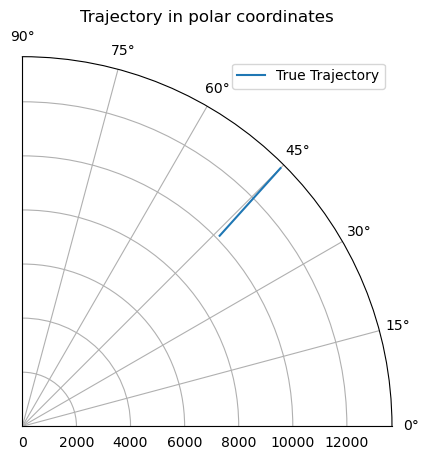

In [6]:
#------------№2------------
#True values of range D and azimuth Beta
D, Beta = generate_Polar_Xt(Xt, N)


# Plot
ax = plt.subplot(111, projection='polar')
ax.plot(Beta[0][0], D[0][0], label='True Trajectory')
ax.set_title('Trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
#ax.set_ylim(9000,12000)
ax.legend()

plt.show()

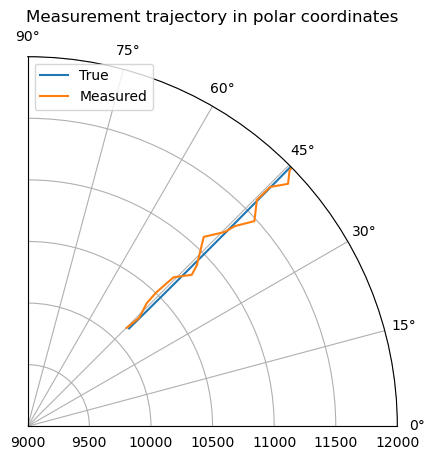

In [7]:
#------------№3------------
#Variances of measurement noises
sigmaD = 20
sigmaB = 0.02
Dz, BetaZ = generate_Polar_Z(sigmaD, sigmaB, D, Beta, N)

# Plot
ax = plt.subplot(111, projection='polar')
ax.plot(Beta[0][0],D[0][0], label='True')
ax.plot(BetaZ[0][0], Dz[0][0], label='Measured')
ax.set_title('Measurement trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
ax.set_ylim(9000,12000)
ax.legend()
ax.grid(True)

plt.show()

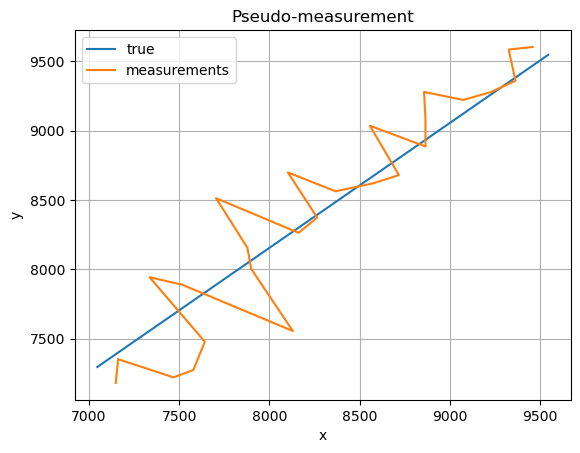

In [8]:
#------------№4,5------------
Zm = pseudo_measurement(Dz, BetaZ, N)

# Plot
plt.plot(Xt[0][0], Xt[2][0], label='true')
plt.plot(Zm[0][0], Zm[1][0], label='measurements')
plt.title('Pseudo-measurement')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#------------№6------------
X0 = np.array([[40000],[-20],[40000],[-20]])
P0 = np.array([[10**10, 0, 0, 0],
               [0, 10**10, 0, 0],
               [0, 0, 10**10, 0],
               [0, 0, 0, 10**10]])

In [8]:
#------------№8------------
#Measurement error covariance matrix
R = Covariance_matrix(sigmaD,sigmaB,Zm,N)

In [10]:
#------------№9------------
Xf, K, Db, Betab, Df, Betaf = kalmanFilter_from_polar_Z(Fi, H, R, X0, P0, Zm, N)


# Plot
plt.plot(Xt[0][0], Xt[2][0], label='X')
plt.plot(Zm[0][0], Zm[1][0], label='Measurement')
plt.plot(Xf[0][0], Xf[2][0], label='Estimated X')
plt.title('X,Measurement, Estimated X')
plt.xlabel('step')
plt.ylabel('Trajectory')
plt.xlim(0,10500)
plt.ylim(0,10500)
plt.grid(True)
plt.legend()

NameError: name 'R' is not defined

NameError: name 'Betab' is not defined

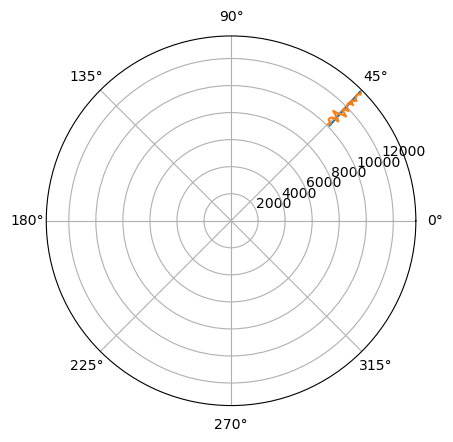

In [11]:

# Plot

ax = plt.subplot(111, projection='polar')
ax.plot(Beta[0][0],D[0][0], label='True')
ax.plot(BetaZ[0][0], Dz[0][0], label='Measured')
ax.plot(Betab[0][0], Db[0][0], label='Filtered')
ax.set_title('Trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
ax.set_ylim(9000,12000)
ax.legend()

plt.show()


In [12]:
#------------№10------------
M = 500
sigmaDM = sigmaD * np.ones(N)
sigmaBM = sigmaB * np.ones(N)

# #mean-squared error
MSE1, MSE2 = calculate_MSE(N, M, x0, sigmaD, sigmaB, Fi, H, R, X0, P0)

# Plot
plt.plot(step, MSE1[0][0], label='Filtration')
plt.plot(step, MSE2[0][0], label='Extrapolation')
plt.plot(step, sigmaDM, label='sigmaDM')
plt.title('True errors of estimation of range D')
plt.xlabel('step')
plt.ylabel('Error')
plt.ylim(0,100)
plt.legend()
plt.grid(True)
plt.show() 

NameError: name 'R' is not defined

In [13]:
# Plot
#mean-squared error
plt.plot(step, MSE1[0][1], label='Filtration')
plt.plot(step, MSE2[0][1], label='Extrapolation')
plt.plot(step, sigmaBM, label='sigmaBM')
plt.title('True errors of estimation of range Beta')
plt.xlabel('step')
plt.ylabel('Error')
plt.ylim(0,0.025)
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'MSE1' is not defined

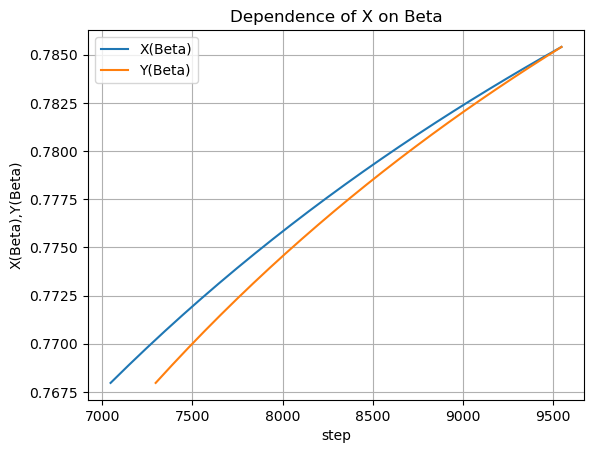

In [13]:
#------------№11------------
plt.plot(Xt[0][0], Beta[0][0], label='X(Beta)')
plt.plot(Xt[2][0], Beta[0][0], label='Y(Beta)')
plt.title('Dependence of X on Beta')
plt.xlabel('step')
plt.ylabel('X(Beta),Y(Beta)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
def condition_number(R: np.array):
    eigenvalues = np.zeros((2, R.shape[0]))
    con_num = np.zeros(R.shape[0])
    for i in range(0, R.shape[0]):
        eigenvalues[:, i], eigenvectors = np.linalg.eig(R[:, :, i])
    
        if eigenvalues[0, i] > eigenvalues[1, i]:
            con_num[i] = eigenvalues[0, i] / eigenvalues[1, i]
        else:
            con_num[i] = eigenvalues[1, i] / eigenvalues[0, i]
    return con_num

In [16]:
R = Covariance_matrix(sigmaD,sigmaB,Zm,N)

In [17]:
R[:,:,0]

array([[13641.7902291 , 17126.84636859],
       [17126.84636859, 22551.75300759]])

In [18]:
condition_number(R)

NameError: name 'condition_number' is not defined

In [19]:
Cond = np.zeros(N)
for i in range(N):
    Cond[i] = np.linalg.cond(R[:,:,i])
    
Cond

array([89.48385809, 86.98552525, 87.68842124, 85.16399851, 82.36291757,
       78.45020399, 78.59160238, 78.60139675, 73.22494957, 76.00137529,
       73.51224053, 70.00955767, 65.64777149, 68.31059448, 66.61322827,
       59.35809033, 62.06788211, 62.39266134, 66.09897841, 56.504542  ,
       53.81205048, 58.40032637, 57.42890093, 55.76729199, 51.28254932,
       51.09728027])

In [28]:
np.linalg.cond(R[:,:,10])

73.51224052944863

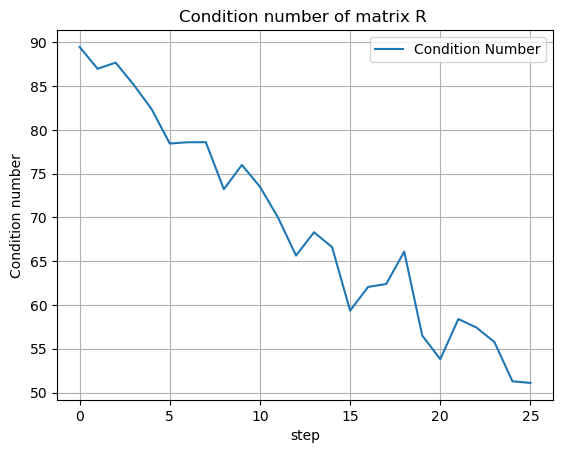

In [20]:
plt.plot(step, Cond, label='Condition Number')
plt.title("Condition number of matrix R ")
plt.xlabel('step')
plt.ylabel('Condition number')
plt.legend()
plt.grid(True)
plt.show()

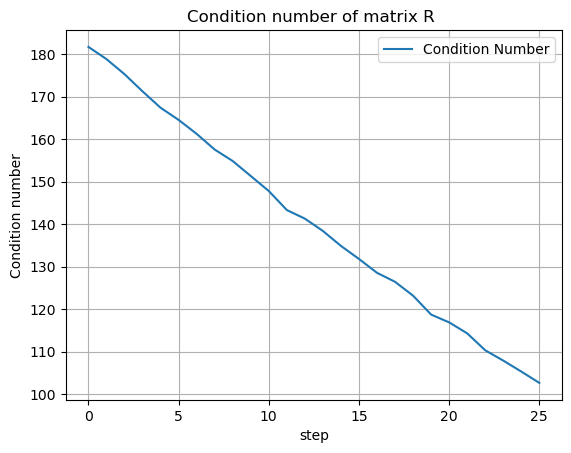

In [31]:
#------------№12------------
#condition number of covariance matrix R
#np.linalg.eig(R[:, :, i])[0] - eigenvalues

#for i in range(N):
#    print(np.linalg.eig(R[:, :, i])[0])
    


ConN1 = np.zeros((2, 1, N))
ConN2 = np.zeros((2, 1, N))
for i in range(N):
    ConN1[:, :, i] = (sigmaD**2)/((Dz[:, :, i]**2)*sigmaB**2)
    ConN2[:, :, i] = ((Dz[:, :, i]**2)*sigmaB**2)/(sigmaD**2)
plt.plot(step, ConN1[0][0] + ConN2[0][0], label='Condition Number')
plt.title("Condition number of matrix R ")
plt.xlabel('step')
plt.ylabel('Condition number')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
ConN1[0][0]/ConN2[0][0]*100000

array([3.02892834, 3.12689768, 3.25463312, 3.41027291, 3.56908807,
       3.69383219, 3.84618272, 4.02832088, 4.17015332, 4.36670584,
       4.57753792, 4.8678703 , 5.0080742 , 5.22019698, 5.49562114,
       5.75483144, 6.05030581, 6.25461582, 6.59068819, 7.09302741,
       7.31724874, 7.65177406, 8.21395132, 8.58727768, 9.01259851,
       9.4877726 ])

In [22]:
R[:,:,26]

IndexError: index 26 is out of bounds for axis 2 with size 26

In [ ]:
#------------№13------------
# Plot
plt.plot(step, K[0][0], label='K')
plt.title('Filter gain K(1,1)')
plt.xlabel('step')
plt.ylabel('K')
plt.legend()
plt.grid(True)
plt.show()

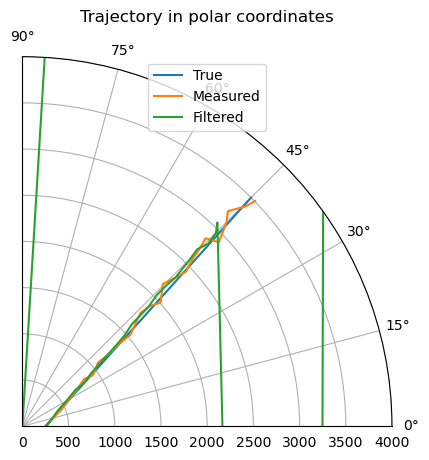

In [20]:
#------------№14------------
x01 = np.array([[3500/np.sqrt(2)], [-50], [3500/np.sqrt(2)], [-45]])

Xt1 = generate_Xt(x01, Fi, N)
D1, Beta1 = generate_Polar_Xt(Xt1, N)
Dz1, BetaZ1 = generate_Polar_Z(sigmaD, sigmaB, D1, Beta1, N)
Zm1 = pseudo_measurement(Dz1, BetaZ1, N)
R1 = Covariance_matrix(sigmaD,sigmaB,Zm1,N)
Xf1, K1, Db1, Betab1, Df1, Betaf1 = kalmanFilter_from_polar_Z(Fi, H, R1, X0, P0, Zm1, N)

#Plot polar
ax = plt.subplot(111, projection='polar')
ax.plot(Beta1[0][0],D1[0][0], label='True') 
ax.plot(BetaZ1[0][0], Dz1[0][0], label='Measured')
ax.plot(Betab1[0][0], Db1[0][0], label='Filtered')
ax.set_title('Trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
ax.set_ylim(0,4000)
ax.legend()

plt.show()

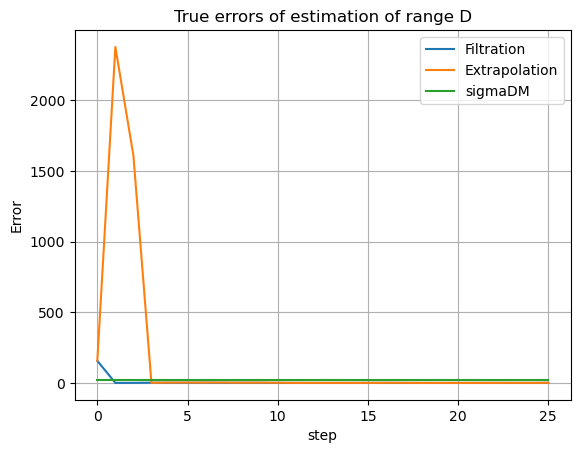

In [21]:
#------------№15------------
#mean-squared error
MSE1_1, MSE2_1 = calculate_MSE(N, M, x01, sigmaD, sigmaB, Fi, H, R, X0, P0)

# Plot
plt.plot(step, MSE1_1[0][0], label='Filtration')
plt.plot(step, MSE2_1[0][0], label='Extrapolation')
plt.plot(step, sigmaDM, label='sigmaDM')
plt.title('True errors of estimation of range D')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


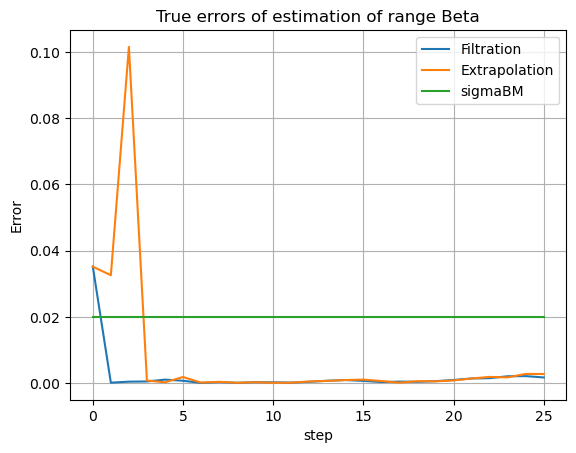

In [22]:
# Plot
#mean-squared error
plt.plot(step, MSE1_1[0][1], label='Filtration')
plt.plot(step, MSE2_1[0][1], label='Extrapolation')
plt.plot(step, sigmaBM, label='sigmaBM')
plt.title('True errors of estimation of range Beta')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

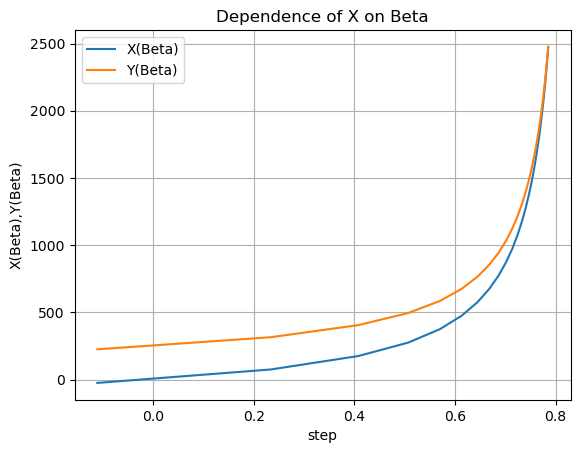

In [23]:
#------------№16------------
plt.plot(Beta1[0][0], Xt1[0][0], label='X(Beta)')
plt.plot(Beta1[0][0], Xt1[2][0], label='Y(Beta)')
plt.title('Dependence of X on Beta')
plt.xlabel('step')
plt.ylabel('X(Beta),Y(Beta)')
plt.legend()
plt.grid(True)
plt.show()


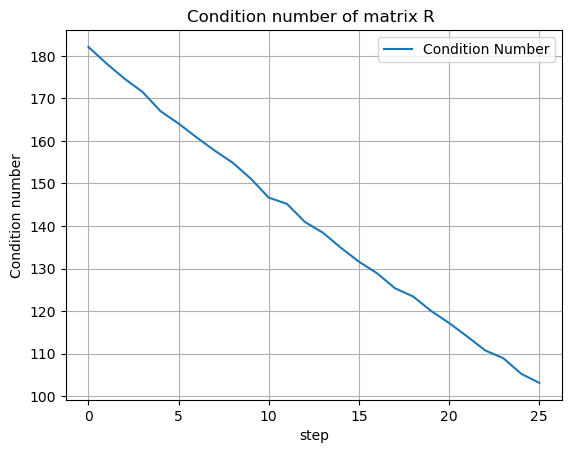

In [24]:
#------------№17------------
ConN1_1 = np.zeros((2, 1, N))
ConN2_1 = np.zeros((2, 1, N))
for i in range(N):
    ConN1_1[:, :, i] = (sigmaD**2)/((Dz[:, :, i]**2)*sigmaB**2)
    ConN2_1[:, :, i] = ((Dz[:, :, i]**2)*sigmaB**2)/(sigmaD**2)
plt.plot(step, ConN2_1[0][0], label='Condition Number')
plt.title("Condition number of matrix R ")
plt.xlabel('step')
plt.ylabel('Condition number')
plt.legend()
plt.grid(True)
plt.show()



In [25]:
#------------№18------------
#Make conclusions how linearization errors affect tracking accuracy and how important for
#tracking accuracy is starting position of a moving object (close or far from an observer).


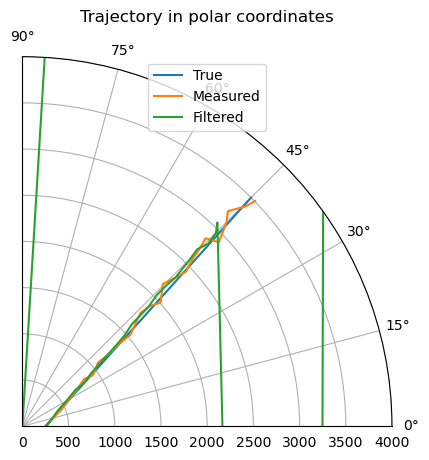

In [26]:
#------------№19------------
sigmaD19 = 50
sigmaB19 = 0.0015

Xt2 = generate_Xt(x01, Fi, N)
D2, Beta2 = generate_Polar_Xt(Xt2, N)
Dz2, BetaZ2 = generate_Polar_Z(sigmaD19, sigmaB19, D1, Beta2, N)
Zm2 = pseudo_measurement(Dz2, BetaZ2, N)
R2 = Covariance_matrix(sigmaD19,sigmaB19,Zm2,N)
Xf2, K2, Db2, Betab2, Df2, Betaf2 = kalmanFilter_from_polar_Z(Fi, H, R2, X0, P0, Zm2, N)

#Plot polar
ax = plt.subplot(111, projection='polar')
ax.plot(Beta1[0][0],D1[0][0], label='True')
ax.plot(BetaZ1[0][0], Dz1[0][0], label='Measured')
ax.plot(Betab1[0][0], Db1[0][0], label='Filtered')
ax.set_title('Trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
ax.set_ylim(0,4000)
ax.legend()

plt.show()


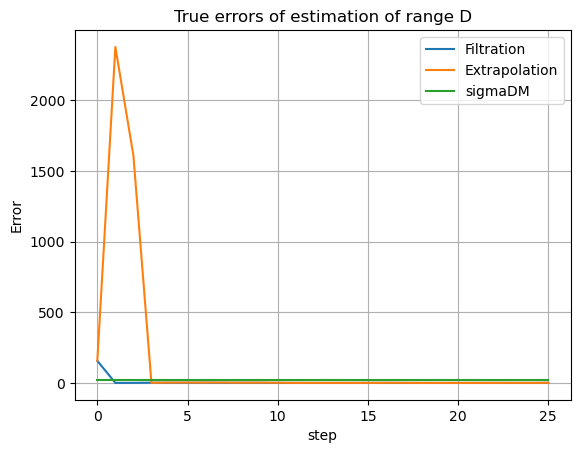

In [27]:
#mean-squared error
MSE1_2, MSE2_2 = calculate_MSE(N, M, x01, sigmaD19, sigmaB19, Fi, H, R, X0, P0)

# Plot
plt.plot(step, MSE1_1[0][0], label='Filtration')
plt.plot(step, MSE2_1[0][0], label='Extrapolation')
plt.plot(step, sigmaDM, label='sigmaDM')
plt.title('True errors of estimation of range D')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

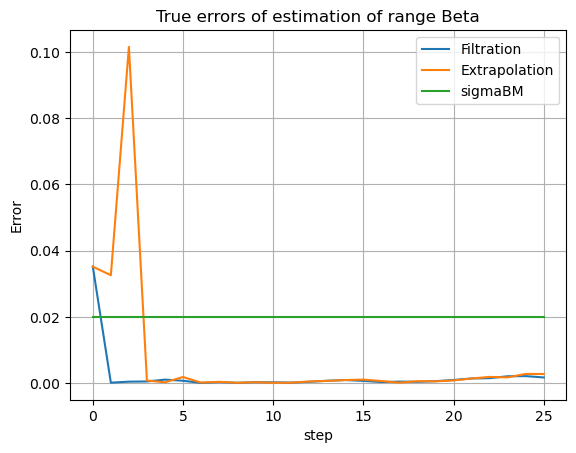

In [28]:
#mean-squared error
plt.plot(step, MSE1_1[0][1], label='Filtration')
plt.plot(step, MSE2_1[0][1], label='Extrapolation')
plt.plot(step, sigmaBM, label='sigmaBM')
plt.title('True errors of estimation of range Beta')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

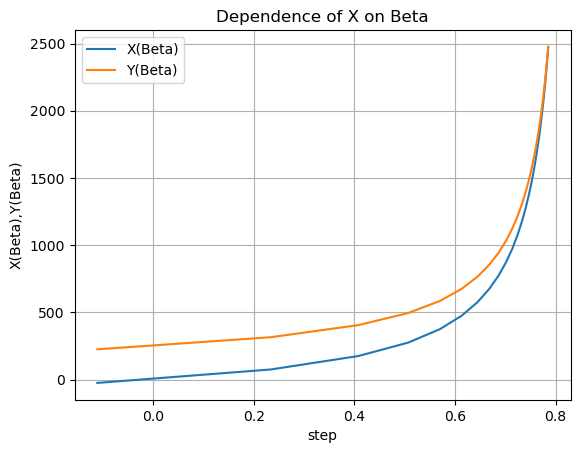

In [29]:
plt.plot(Beta2[0][0], Xt2[0][0], label='X(Beta)')
plt.plot(Beta2[0][0], Xt2[2][0], label='Y(Beta)')
plt.title('Dependence of X on Beta')
plt.xlabel('step')
plt.ylabel('X(Beta),Y(Beta)')
plt.legend()
plt.grid(True)
plt.show()

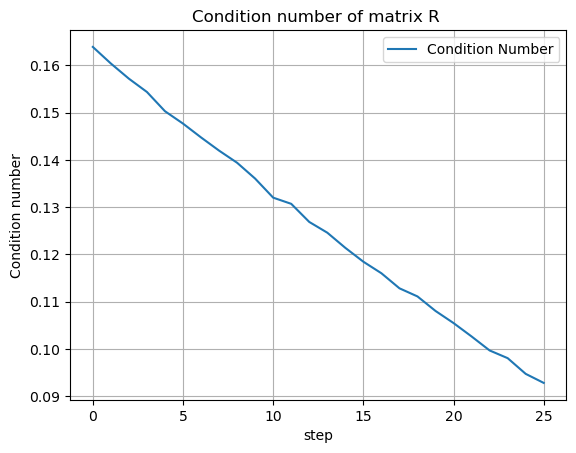

In [30]:
ConN1_2 = np.zeros((2, 1, N))
ConN2_2 = np.zeros((2, 1, N))
for i in range(N):
    ConN1_2[:, :, i] = (sigmaD19**2)/((Dz[:, :, i]**2)*sigmaB19**2)
    ConN2_2[:, :, i] = ((Dz[:, :, i]**2)*sigmaB19**2)/(sigmaD19**2)
plt.plot(step, ConN2_2[0][0], label='Condition Number')
plt.title("Condition number of matrix R ")
plt.xlabel('step')
plt.ylabel('Condition number')
plt.legend()
plt.grid(True)
plt.show()